In [7]:
# We will be using satimage data as in the Borderline-SMOTE paper
from sklearn.datasets import fetch_openml
import pandas as pd
import gc

data = fetch_openml(name='satimage')
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# treat 4 as the target class
y = (y=='4.').astype(int)
y.mean()

del data
gc.collect()

37

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y, shuffle=True, random_state=1024)

def evaluate(clf):
    pred_proba = clf.predict_proba(X_test)[:, 1]
    pred = clf.predict(X_test)
    metric = 'AUC: {}\nRecall: {}\nPrecision: {}\nF1: {}\n'.format(roc_auc_score(y_test, pred_proba),
                                                              recall_score(y_test, pred),
                                                              precision_score(y_test, pred),
                                                              f1_score(y_test, pred))
    print(metric)

clf = RandomForestClassifier(n_estimators=100, random_state=1024)

In [9]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

In [107]:
def standardize(x):
    mean_, var_ = tf.nn.moments(x, axes=[0], keepdims=True)
    return (x - mean_) / tf.sqrt(var_)

In [108]:
N_FEATURE = X_train.shape[1]
BATCH_SIZE = 128

train_dataset =tf.data.Dataset.from_tensor_slices(X_train.values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test.values.astype('float32')) \
    .shuffle(10000).batch(10000).map(standardize)

# all positive samples
train_pos_dataset = tf.data.Dataset.from_tensor_slices(X_train[y_train==1].values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_pos_dataset = tf.data.Dataset.from_tensor_slices(X_test[y_test==1].values.astype('float32')) \
    .shuffle(10000).batch(100).map(standardize)

In [109]:
sample = next(iter(train_pos_dataset))
sample.shape

TensorShape([128, 36])

In [110]:
def make_generator(hidden_size):
    g = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(hidden_size,)),
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dense(N_FEATURE, activation=None),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dense(N_FEATURE, activation=None),
        keras.layers.LeakyReLU(0.2)
    ])
    return g

def make_discriminator():
    d = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(N_FEATURE,)),
        keras.layers.Dense(N_FEATURE, activation='relu'),
        keras.layers.Dense(18, activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return d

In [126]:
class WGAN(keras.models.Model):
    
    def __init__(self, gen_opt=None, disc_opt=None, hidden_size=8, lambda_=10.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.lambda_ = lambda_
        self.gen = make_generator(hidden_size)
        self.disc = make_discriminator()
        
        self.gen_opt = gen_opt or keras.optimizers.Adam(0.0001, beta_1=0.5)
        self.disc_opt = disc_opt or keras.optimizers.RMSprop(0.0005, momentum=0.6)
    
    def generate(self, z):
        return self.gen(z)
    
    def discriminate(self, x):
        return self.disc(x)
    
    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as tape:
            tape.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        
        gradients = tape.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    def compute_loss(self, x):
        sample = tf.random.normal((x.shape[0], self.hidden_size))
        x_gen = self.generate(sample)
        
        # run through discriminator
        logits_x = self.discriminate(x)
        logits_gen = self.discriminate(x_gen)
        
        # loss
        gradient_loss = self.gradient_penalty(x, x_gen)
        disc_loss = tf.reduce_mean(logits_gen - logits_x) + self.lambda_ * gradient_loss
        gen_loss = tf.reduce_mean(1-logits_gen)
        return disc_loss, gen_loss
    
    @tf.function
    def train_generator(self, x):
        with tf.GradientTape() as tape:
            _, gen_loss = self.compute_loss(x)
        gradients = tape.gradient(gen_loss, self.gen.trainable_variables)
        self.gen_opt.apply_gradients(zip(gradients, self.gen.trainable_variables))
    
    @tf.function
    def train_discriminator(self, x):
        with tf.GradientTape() as tape:
            disc_loss, _ = self.compute_loss(x)
        gradients = tape.gradient(disc_loss, self.disc.trainable_variables)
        self.disc_opt.apply_gradients(zip(gradients, self.disc.trainable_variables))
    
#     @tf.function
    def train(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        
        self.gen_opt.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_opt.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))        

### Train the model

In [124]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005, momentum=0.0)
model = WGAN(gen_opt=gen_optimizer, disc_opt=disc_optimizer, hidden_size=8, lambda_=10.0)


n_epochs = 5

for epoch in tqdm(range(n_epochs)):
    # train
    for train_x in train_dataset:
        model.train(train_x)
    
    # test on holdout
    loss = []
    for test_x in test_dataset:
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )

Tensor("add_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32)
Tensor("add_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32)
Tensor("add_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32)
Epoch: 0 | disc_loss: nan | gen_loss: nan
Epoch: 1 | disc_loss: nan | gen_loss: nan
Epoch: 2 | disc_loss: nan | gen_loss: nan
Epoch: 3 | disc_loss: nan | gen_loss: nan
Epoch: 4 | disc_loss: nan | gen_loss: nan



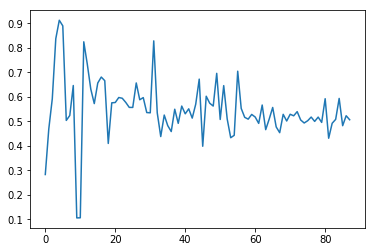

In [0]:
# plot the loss throughout the training
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.subplot(1, 1, 1)
ax.plot(losses.index, losses.disc_loss, label='disc_loss')

ax2 = ax.twinx()
ax2.plot(losses.index, losses.gen_loss, label='gen_loss', color='orange')
ax.figure.legend(loc='best')